In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
print('Use CUDA:', torch.cuda.is_available())

Use CUDA: True


In [ ]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [ ]:
def reshape_instance(ins):
  _,size,_,_=ins.shape
  return ins.reshape(3,size,25)


In [ ]:
def crop_clip(data , length=300):
  for item_iter in range(len(data)):
    if data[item_iter].shape[1]>length:
      data[item_iter]= data[item_iter][:,:length,:]
  return data

### Loading Dataset pickles

In [ ]:
import pickle
with open('/content/drive/MyDrive/Park/train_3d.pkl', 'rb') as f:
    train_data = pickle.load(f)
    # train_label = [int(i['label']/10) for i in train_data]
    train_label = [i['label'] for i in train_data]
    print(train_label[:10])
    train_data = [reshape_instance(i['keypoint']) for i in train_data]

with open('/content/drive/MyDrive/Park/test_3d.pkl', 'rb') as f:
    test_data = pickle.load(f)
    # test_label = [int(i['label']/10) for i in test_data]
    test_label = [i['label'] for i in test_data]
    print(test_label[:10])
    test_data = [reshape_instance(i['keypoint']) for i in test_data]


with open('/content/drive/MyDrive/Park/val_3d.pkl', 'rb') as f:
    val_data = pickle.load(f)
    # val_label = [int(i['label']/10) for i in val_data]
    val_label = [i['label'] for i in val_data]
    print(val_label[:10])
    val_data = [reshape_instance(i['keypoint']) for i in val_data]

train_data = crop_clip(train_data)
test_data = crop_clip(test_data)
val_data = crop_clip(val_data)

[71, 24, 87, 93, 69, 51, 21, 79, 36, 79]
[21, 63, 87, 1, 2, 59, 30, 16, 8, 26]
[5, 9, 52, 93, 4, 71, 59, 13, 7, 87]


In [ ]:
max(train_label)

96

### Defining collator and feeder

In [ ]:
from keras.preprocessing import sequence
from torch.nn.utils.rnn import pad_sequence
class MyCollator(object):   # makes data on each batch, same in size(length) here length will be at most 300.
    def __init__(self,test=False,percentile=4750):
        self.test = test
        self.percentile = percentile
    def __call__(self, batch):
        max_len = 300 # default max len
        max_len2 = max([x[0].shape[2] for x in batch]) # max len of all instances
        batch = sorted(batch, key=lambda x: x[0].shape[1], reverse=True) # sort data of batch based on length
        target = [item[1] for item in batch]# list of labels
        data = [torch.Tensor(item[0]) for item in batch]# list of data
        padded_batch = [torch.nn.functional.pad(torch.Tensor(gif[0]), ( 0,0,max_len - gif[0].shape[1], 0)) for gif in batch] # make data the same length here
        return [torch.stack(padded_batch),target] # concat padded_data and labels as new batch. now the model will be error free




In [ ]:

class Feeder(torch.utils.data.Dataset): # feeds data to model
  def __init__(self, data, label):
      super().__init__()
      self.label = label
      self.data = data

  def __len__(self):
      return len(self.label)

  def __iter__(self):
      return self

  def __getitem__(self, index):
      data = np.array(self.data[index])
      label = self.label[index]

      return data, label

### Defining Graph to load data in the way ntu+rgb D models give it to action recongnition model

In [ ]:
class Graph():
  def __init__(self, hop_size, strategy):
    self.get_edge()

    self.hop_size = hop_size # nodes to pass in each traverse
    self.hop_dis = self.get_hop_distance(self.num_node, self.edge, hop_size=hop_size)

    self.get_adjacency(strategy)

  def __str__(self):
    return self.A

  def get_edge(self): # get connected edges in this graph
    self.num_node = 25 # its based on the data, experimental
    self_link = [(i, i) for i in range(self.num_node)] #edges to the nodes themselves
    neighbor_base = [(1, 2), (2, 21), (3, 21), (4, 3), (5, 21), # Main nodes, its based on the data, experimental
                      (6, 5), (7, 6), (8, 7), (9, 21), (10, 9),
                      (11, 10), (12, 11), (13, 1), (14, 13), (15, 14),
                      (16, 15), (17, 1), (18, 17), (19, 18), (20, 19),
                      (22, 23), (23, 8), (24, 25), (25, 12)]
    neighbor_link = [(i - 1, j - 1) for (i, j) in neighbor_base] # edges to neighbors of the main nodes, its based on the data, experimental
    self.self_link = self_link
    self.neighbor_link = neighbor_link
    self.edge = self_link + neighbor_link # all the edges
    self.center = 21 - 1     # central node

  def get_adjacency(self, strategy):
    valid_hop = range(0, self.hop_size + 1, 1) # how many nodes to traverse
    adjacency = np.zeros((self.num_node, self.num_node)) # builds a matrix
    for hop in valid_hop:
        adjacency[self.hop_dis == hop] = 1 # mark the traverse
    normalize_adjacency = self.normalize_digraph(adjacency) # normalization  https://coresignal.com/blog/data-normalization/#:~:text=The%20main%20objective%20of%20database,increase%20security%2C%20and%20lessen%20costs.

    if strategy == 'spatial': # spatial technique

    # """traverses the graph from the central node (root) to a fixed distance (hop size) until it reaches closure.(close)
    # this travers makes a circle in the graph, like a domain where we expect main concept of the data,
    # for example if the purpose was to find cars, the central node would be somewhere in street, and the domain would be a
    # circle in street, all other places would be less important and called (further)"""

      A = []
      for hop in valid_hop:
          a_root = np.zeros((self.num_node, self.num_node))
          a_close = np.zeros((self.num_node, self.num_node))
          a_further = np.zeros((self.num_node, self.num_node))
          for i in range(self.num_node):
              for j in range(self.num_node):
                  if self.hop_dis[j, i] == hop:
                      if self.hop_dis[j, self.center] == self.hop_dis[
                              i, self.center]:
                          a_root[j, i] = normalize_adjacency[j, i]
                      elif self.hop_dis[j, self.center] > self.hop_dis[
                              i, self.center]:
                          a_close[j, i] = normalize_adjacency[j, i]
                      else:
                          a_further[j, i] = normalize_adjacency[j, i]
          if hop == 0:
              A.append(a_root)
          else:
              A.append(a_root + a_close)
              A.append(a_further)
      A = np.stack(A)
      self.A = A
    elif strategy == 'agcn':
      """
        this time makes a matrix of the nodes, and analyzes these nodes connections
      """
      A = []
      link_mat = self.edge2mat(self.self_link, self.num_node) #matrix of connections
      In = self.normalize_digraph(self.edge2mat(self.neighbor_link, self.num_node)) #normalization of graph
      outward = [(j, i) for (i, j) in self.neighbor_link] #connection of each node
      Out = self.normalize_digraph(self.edge2mat(outward, self.num_node)) #normalization
      A = np.stack((link_mat, In, Out)) # concat of all info for future use like , connections (link_mat),graph(IN), OUT (connection of each edge)
      self.A = A
    else:
        raise ValueError('Do Not Exist This Strategy')

  def get_hop_distance(self, num_node, edge, hop_size): # traverse distance
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1
    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(hop_size + 1)]
    arrive_mat = (np.stack(transfer_mat) > 0)
    for d in range(hop_size, -1, -1):
        hop_dis[arrive_mat[d]] = d
    return hop_dis

  def normalize_digraph(self, A): # normalization
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-1)
    DAD = np.dot(A, Dn)
    return DAD

  def edge2mat(self, link, num_node): # matrix of edges
    A = np.zeros((num_node, num_node))
    for i, j in link:
        A[j, i] = 1
    return A

### Attention Module class

In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # adaptiveavgpool2d reduces tensor dimensions to (b, c, 1, 1)


        self.fc = nn.Sequential(# fully connected layers to learn channel-wise attention weights

            nn.Linear(in_channels, in_channels // reduction),# first linear layer reduces input channels to in_channels // reduction
            nn.ReLU(),# second linear layer maps back to the original number of channels
            nn.Linear(in_channels // reduction, in_channels),
            nn.Sigmoid()  # activation function to generate attention weights
        )

    def forward(self, x):
        b, c, _, _ = x.size()# retrieve batch size (b), number of channels (c), height, and width from input tensor
        y = self.avg_pool(x).view(b, c)#apply adaptive average pooling to reduce spatial dimensions to 1x1
          #apply fully connected layers to generate channel-wise attention weights
        y = self.fc(y).view(b, c, 1, 1)  # reshape to (b, c, 1, 1) to match the input tensor shape

        # scale the input feature map 'x' by the computed attention weights
        return x * y


### AGCN Backbone

In [ ]:
import math
import torch.nn as nn
import torch.nn.init as init

def kaiming_init(module: nn.Module, #This function performs weight initialization using the Kaiming initialization method. https://towardsdatascience.com/understand-kaiming-initialization-and-implementation-detail-in-pytorch-f7aa967e9138?gi=74574e4cbbbf
                 a: float = 0,
                 mode: str = 'fan_out',
                 nonlinearity: str = 'relu',
                 bias: float = 0,
                 distribution: str = 'normal') -> None:
    # initialization method for weights using Kaiming initialization
    assert distribution in ['uniform', 'normal']
    if hasattr(module, 'weight') and module.weight is not None:
        if distribution == 'uniform':
            # kaiming initialization for weights with a uniform distribution
            init.kaiming_uniform_(
                module.weight, a=a, mode=mode, nonlinearity=nonlinearity)
        else:
            # kaiming initialization for weights with a normal distribution
            init.kaiming_normal_(
                module.weight, a=a, mode=mode, nonlinearity=nonlinearity)
    if hasattr(module, 'bias') and module.bias is not None:
        # constant initialization for bias
        init.constant_(module.bias, bias)


def constant_init(module: nn.Module, val: float, bias: float = 0) -> None:
    # initialization for weights with a constant value
    if hasattr(module, 'weight') and module.weight is not None:
        init.constant_(module.weight, val)
    if hasattr(module, 'bias') and module.bias is not None:
        # constant initialization for bias
        init.constant_(module.bias, bias)


def normal_init(module: nn.Module,
                mean: float = 0,
                std: float = 1,
                bias: float = 0) -> None:
    # initialization for weights with a normal distribution
    if hasattr(module, 'weight') and module.weight is not None:
        init.normal_(module.weight, mean, std)
    if hasattr(module, 'bias') and module.bias is not None:
        # constant initialization for bias
        init.constant_(module.bias, bias)


def conv_branch_init(conv, branches):
    # initialization for convolutional layer weights based on branches
    weight = conv.weight
    n = weight.size(0)
    k1 = weight.size(1)
    k2 = weight.size(2)
    # normal initialization for weights with calculated parameters
    normal_init(weight, mean=0, std=math.sqrt(2. / (n * k1 * k2 * branches)))
    # constant initialization for bias
    constant_init(conv.bias, 0)


def conv_init(conv):
    # kaiming initialization for convolutional layer weights
    kaiming_init(conv.weight)
    # constant initialization for bias
    constant_init(conv.bias, 0)


def bn_init(bn, scale):
    # constant initialization for BatchNorm layer weights and bias
    constant_init(bn.weight, scale)
    constant_init(bn.bias, 0)


def zero(x):
    # Return zero
    return 0


def identity(x):
    # Return the input itself
    return x


In [ ]:
import torch
import torch.nn as nn

class ConvTemporalGraphical(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 t_kernel_size=1,
                 t_stride=1,
                 t_padding=0,
                 t_dilation=1,
                 adj_len=25,
                 bias=True):
        super().__init__()

        self.kernel_size = kernel_size
        #initialize a learnable parameter for adjacency matrix
        self.PA = nn.Parameter(torch.FloatTensor(5, adj_len, adj_len))
        torch.nn.init.constant_(self.PA, 1e-6)  # initialize the parameter to a constant value

        self.num_subset = 3  # define the number of subsets
        inter_channels = out_channels // 4  # calculate intermediate channels based on output channels
        self.inter_c = inter_channels
        self.conv_a = nn.ModuleList()  # initialize convolutional layers in ModuleList
        self.conv_b = nn.ModuleList()
        self.conv_d = nn.ModuleList()
        for i in range(self.num_subset):
            # append convolutional layers to lists
            self.conv_a.append(nn.Conv2d(in_channels, inter_channels, 1))
            self.conv_b.append(nn.Conv2d(in_channels, inter_channels, 1))
            self.conv_d.append(nn.Conv2d(in_channels, out_channels, 1))

        # downsample layer if input channels are not equal to output channels
        if in_channels != out_channels:
            self.down = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1),
                nn.BatchNorm2d(out_channels))
        else:
            self.down = lambda x: x  # identity function if channels are the same

        # batch normalization layer, softmax, and ReLU activation
        self.bn = nn.BatchNorm2d(out_channels)
        self.soft = nn.Softmax(-2)
        self.relu = nn.ReLU()

        # initialize weights and biases for convolutional and batch norm layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                conv_init(m)
            elif isinstance(m, nn.BatchNorm2d):
                bn_init(m, 1)
        bn_init(self.bn, 1e-6)
        for i in range(self.num_subset):
            conv_branch_init(self.conv_d[i], self.num_subset)

    def forward(self, x, adj_mat):
        """Defines the computation performed at every call."""
        assert adj_mat.size(0) == self.kernel_size  # ensure adjacency matrix size matches kernel size

        N, C, T, V = x.size()  # get the dimensions of the input tensor x
        A = adj_mat + self.PA  # add the learnable parameter to the adjacency matrix

        y = None
        for i in range(self.num_subset):
            A1 = self.conv_a[i](x).permute(0, 3, 1, 2).contiguous().view(
                N, V, self.inter_c * T)  # apply convolution and reshape
            A2 = self.conv_b[i](x).view(N, self.inter_c * T, V)  # apply convolution and reshape
            A1 = self.soft(torch.matmul(A1, A2) / A1.size(-1))  # apply softmax on the matrix
            A1 = A1 + A[i]  # add matrix A[i] to A1
            A2 = x.view(N, C * T, V)  # Reshape input x
            z = self.conv_d[i](torch.matmul(A2, A1).view(N, C, T, V))  # matrix multiplication and convolution
            y = z + y if y is not None else z  # accumulate output results
        y = self.bn(y)  # apply batch normalization
        y += self.down(x)  # add the result of the downsample layer

        return self.relu(y), adj_mat  # apply ReLU activation and return result, adj_mat


In [ ]:
class AGCNBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 adj_len=25,
                 dropout=0,
                 residual=True):
        super().__init__()

        assert len(kernel_size) == 2
        assert kernel_size[0] % 2 == 1
        padding = ((kernel_size[0] - 1) // 2, 0)

        #  Graph convolutional layer
        self.gcn = ConvTemporalGraphical(
            in_channels, out_channels, kernel_size[1], adj_len=adj_len)

        # temporal convolutional layer
        self.tcn = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, (kernel_size[0], 1),
                      (stride, 1), padding), nn.BatchNorm2d(out_channels))

        # initialize TCN layers
        for m in self.tcn.modules():
            if isinstance(m, nn.Conv2d):
                conv_init(m)
            elif isinstance(m, nn.BatchNorm2d):
                bn_init(m, 1)

        # define residual connection / pass or process ? as we talked in the meeting
        if not residual:
            self.residual = zero  # Function returning zero
        elif (in_channels == out_channels) and (stride == 1):
            self.residual = identity  # Function returning input itself
        else:
            self.residual = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=(stride, 1)), nn.BatchNorm2d(out_channels))

        self.relu = nn.ReLU(inplace=True)

        # attention mechanisms (PAM, CAM)
        self.att_type = []  # list of attention types
        self.attention = len(self.att_type)
        if self.attention > 0:
            self.channel_attention = ChannelAttention(out_channels)  # channelAttention module

    def forward(self, x, adj_mat):
        """Defines the computation performed at every call."""
        res = self.residual(x)  # calculate residual connection
        x, adj_mat = self.gcn(x, adj_mat)  # graph convolutional layer

        # apply attention mechanisms
        if self.attention == 1 and self.att_type[0] == 'pam':
            x = self.channel_attention(x)
            x = self.tcn(x)
            x = x + res
        elif self.attention == 1 and self.att_type[0] == 'cam':
            x = self.tcn(x)
            x = self.channel_attention(x)
            x = x + res
        else:
            x = self.tcn(x) + res

        if self.attention == 2:
            x = self.channel_attention(x)  # apply channel attention

        return self.relu(x), adj_mat  # apply ReLU activation and return result, adj_mat


#what are backbone and head in mmaction models ?
model = dict(
    type='',
    backbone=dict(
        ),
    cls_head=dict(
       ),
    train_cfg=None,
    test_cfg=None)
## type:
The type parameter defines the type or the class name of the model. It specifies the category or kind of model architecture being used for action recognition. it defines specific architecture type designed for action recognition. The value assigned to type will refer to a specific class or model type within the MMAction framework.
##backbone:
The backbone parameter defines the architecture or structure of the backbone network used in the model. The backbone network is responsible for feature extraction from input frames or clips. This section typically includes settings such as layer types, number of layers, layer configurations, etc. It refers to the deep models or any other base network architecture used as a feature extractor.
##head
The cls_head parameter defines the architecture of the classification head. It usually includes fully connected layers or other structures responsible for mapping the extracted features from the backbone into class probabilities or scores. This part is specifically designed for action recognition tasks and is responsible for the final classification or prediction based on the features extracted by the backbone.

In [ ]:
class AGCN(nn.Module):
    def __init__(self, in_channels, hop_size, strategy, pretrained=None, **kwargs):
        super().__init__()

        # graph/ the gigantic model before this architecture
        self.graph = Graph(hop_size, strategy)
        A = torch.tensor(self.graph.A, dtype=torch.float32, requires_grad=False)
        self.register_buffer('A', A)
        A_size = A.size()

        # batch normalization
        self.bn = nn.BatchNorm1d(in_channels * A_size[1])

        # AGCN Blocks
        spatial_kernel_size = A.size(0)
        temporal_kernel_size = 9
        kernel_size = (temporal_kernel_size, spatial_kernel_size)

        # initializing AGCN network with several AGCNBlocks
        kwargs0 = {k: v for k, v in kwargs.items() if k != 'dropout'}
        self.agcn_networks = nn.ModuleList([
            AGCNBlock(in_channels, 64, kernel_size, 1, adj_len=A.size(1), residual=False, **kwargs0),
            AGCNBlock(64, 64, kernel_size, 1, adj_len=A.size(1), **kwargs),
            AGCNBlock(64, 64, kernel_size, 1, adj_len=A.size(1), **kwargs),
            AGCNBlock(64, 64, kernel_size, 1, adj_len=A.size(1), **kwargs),
            AGCNBlock(64, 128, kernel_size, 2, adj_len=A.size(1), **kwargs),
            AGCNBlock(128, 128, kernel_size, 1, adj_len=A.size(1), **kwargs),
            AGCNBlock(128, 128, kernel_size, 1, adj_len=A.size(1), **kwargs),
            AGCNBlock(128, 256, kernel_size, 2, adj_len=A.size(1), **kwargs),
            AGCNBlock(256, 256, kernel_size, 1, adj_len=A.size(1), **kwargs),
            AGCNBlock(256, 256, kernel_size, 1, adj_len=A.size(1), **kwargs),
        ])

    def forward(self, x):
        N, C, T, V = x.size()  # batch, channel, frame, node

        # data normalization
        x = x.permute(0, 3, 1, 2).contiguous().view(N, V * C, T)
        x = self.bn(x)
        x = x.view(N, V, C, T).permute(0, 2, 3, 1).contiguous()

        # looping through AGCN blocks
        for gcn in self.agcn_networks:
            x, _ = gcn(x, self.A)

        return x


### STGCN head

In [ ]:
class STGCNHead(nn.Module):
    def __init__(self,
                 num_classes,
                 in_channels,
                 loss_cls=dict(type='CrossEntropyLoss'),
                 spatial_type='avg',
                 num_person=1,
                 init_std=0.01,
                 **kwargs):
        super().__init__()

        self.spatial_type = spatial_type
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_person = num_person
        self.init_std = init_std

        # pooling layer selection based on spatial type
        self.pool = None
        if self.spatial_type == 'avg':
            self.pool = nn.AdaptiveAvgPool2d((1, 1))
        elif self.spatial_type == 'max':
            self.pool = nn.AdaptiveMaxPool2d((1, 1))
        else:
            raise NotImplementedError

        # fully connected layer for classification
        self.fc = nn.Conv2d(self.in_channels, self.num_classes, kernel_size=1)

    def init_weights(self):
        # weight initialization for the fully connected layer
        normal_init(self.fc, std=self.init_std)

    def forward(self, x):
        # global pooling
        assert self.pool is not None
        x = self.pool(x)
        x = x.view(x.shape[0] // self.num_person, self.num_person, -1, 1, 1).mean(dim=1)

        # prediction
        x = self.fc(x)
        x = x.view(x.shape[0], -1)

        return x


### Model Definition

#### STGCN

In [ ]:

class STGCN(nn.Module):
  def __init__(self,
               num_classes,
               in_channels,
               t_kernel_size,
               hop_size,
               strategy='spatial'):
    super().__init__()

    self.agcn = AGCN(in_channels, hop_size, strategy)
    self.stgcnhead = STGCNHead(num_classes, in_channels=256)

  def forward(self, x):
    x = self.agcn(x)
    x = self.stgcnhead(x)

    return x


### Training Loop

In [ ]:
import os
#---------------------------------------------------------------------------parameters and model
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

NUM_EPOCH = 80
BATCH_SIZE = 32
CUDA_LAUNCH_BLOCKING=1
if(torch.cuda.is_available()):
  model = STGCN(num_classes=99,
                    in_channels=3,
                    t_kernel_size=9,
                    hop_size=2).cuda()
else:
  model = STGCN(num_classes=99,
                    in_channels=3,
                    t_kernel_size=9,
                    hop_size=2)


#---------------------------------------------------------------------------optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001, nesterov=True)
criterion = torch.nn.CrossEntropyLoss()

#---------------------------------------------------------------------------here we are defining data and using collator so the model would work error free when facing variant dadta
data_loader = dict()
collator = MyCollator()
data_loader['train'] = torch.utils.data.DataLoader(dataset=Feeder(data=train_data, label=train_label), batch_size=BATCH_SIZE, shuffle=True,collate_fn=collator)
data_loader['valid'] = torch.utils.data.DataLoader(dataset=Feeder(data=val_data, label=val_label), batch_size=BATCH_SIZE, shuffle=True,collate_fn=collator)
data_loader['test'] = torch.utils.data.DataLoader(dataset=Feeder(data=test_data, label=test_label), batch_size=BATCH_SIZE, shuffle=False,collate_fn=collator)

#---------------------------------------------------------------------------training
model.train()

for epoch in range(1, NUM_EPOCH+1):
  correct_train = 0
  sum_loss = 0
  model.train()
  for batch_idx, (data, label) in enumerate(data_loader['train']):
    # print(data)
    if(torch.cuda.is_available()):
      data = data.cuda()
      label = torch.LongTensor(label).cuda()
    else:
      data = data
      label = torch.LongTensor(label)

#---------------------------------------------------------------------------inference
    output = model(data)
    # print(len(output),len(label))
#---------------------------------------------------------------------------optimization and learning
    loss = criterion(output, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
#---------------------------------------------------------------------------training metrics
    sum_loss += loss.item()
    _, predict = torch.max(output.data, 1)
    correct_train += (predict == label).sum().item()
#---------------------------------------------------------------------------evaluation
  model.eval()
  val_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
      for data, label in data_loader['valid']:
          if(torch.cuda.is_available()):
            data = data.cuda()
            label = torch.LongTensor(label).cuda()
          else:
            data = data
            label = torch.LongTensor(label)
#---------------------------------------------------------------------------inference
          outputs = model(data)
#---------------------------------------------------------------------------evaluation metrics
          val_loss =criterion(outputs, label)

          sum_loss += val_loss.item()
          _, predict = torch.max(outputs.data, 1)
          correct += (predict == label).sum().item()



  print('# Epoch: {} | Train Loss: {:.4f} | Train Accuracy: {:.4f} | Val loss: {:.4f} | Val Accuracy: {:.4f}'.format(epoch, sum_loss/len(data_loader['train'].dataset),(100. * correct_train / len(data_loader['train'].dataset)),val_loss/len(data_loader['valid'].dataset), (100. * correct / len(data_loader['valid'].dataset))))

# Epoch: 1 | Train Loss: 0.1441 | Train Accuracy: 5.1279 | Val loss: 0.0032 | Val Accuracy: 7.3402
# Epoch: 2 | Train Loss: 0.1214 | Train Accuracy: 12.9832 | Val loss: 0.0028 | Val Accuracy: 9.3923
# Epoch: 3 | Train Loss: 0.1102 | Train Accuracy: 17.1982 | Val loss: 0.0026 | Val Accuracy: 17.2849
# Epoch: 4 | Train Loss: 0.1041 | Train Accuracy: 20.2637 | Val loss: 0.0020 | Val Accuracy: 16.2589
# Epoch: 5 | Train Loss: 0.0979 | Train Accuracy: 23.5433 | Val loss: 0.0025 | Val Accuracy: 19.8895
# Epoch: 6 | Train Loss: 0.0940 | Train Accuracy: 27.7358 | Val loss: 0.0022 | Val Accuracy: 19.5738
# Epoch: 7 | Train Loss: 0.0886 | Train Accuracy: 31.7931 | Val loss: 0.0018 | Val Accuracy: 25.8090
# Epoch: 8 | Train Loss: 0.0811 | Train Accuracy: 37.5859 | Val loss: 0.0023 | Val Accuracy: 28.8082
# Epoch: 9 | Train Loss: 0.0747 | Train Accuracy: 43.4577 | Val loss: 0.0019 | Val Accuracy: 25.4144
# Epoch: 10 | Train Loss: 0.0657 | Train Accuracy: 49.3407 | Val loss: 0.0020 | Val Accuracy: 

### Evaluation of Model

In [ ]:
import imageio
from PIL import Image
def prepare_gif_for_model(gif_path,length=300):
  gif = imageio.mimread(gif_path)
  resized_frames = []
  for frame in gif:
      image = Image.fromarray(frame)
      resized_image = image.resize((25, 25))
      resized_frames.append(np.array(resized_image))
  frames = np.asarray(resized_frames)
  frames = np.transpose(frames, (3, 0, 1, 2))


  frames=frames.reshape((3,-1,25)) #check this
  if frames.shape[1]>length:
      frames= frames[:,:length,:]
  data = torch.Tensor(frames)

  return np.array(data)

In [ ]:
train_data[1].shape

(3, 119, 25)

#test one file

In [ ]:
instance=prepare_gif_for_model("/content/205_18_0_1_1_stand.txt.gif")

In [ ]:
model.eval()
with torch.no_grad():
    if(torch.cuda.is_available()):
        data = torch.tensor([instance]).cuda()
    else:
        data = torch.tensor([instance])

    output = model(data)

    _, predict = torch.max(output.data, 1)

print(predict)

tensor([6], device='cuda:0')


<ipython-input-23-59746615cba0>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  data = torch.tensor([instance]).cuda()


#test pack of files

<ipython-input-24-42adc96eb609>:27: RuntimeWarning: invalid value encountered in double_scalars
  confusion_matrix[i][j] = 100 * (confusion_matrix[i][j] / sum_cm)


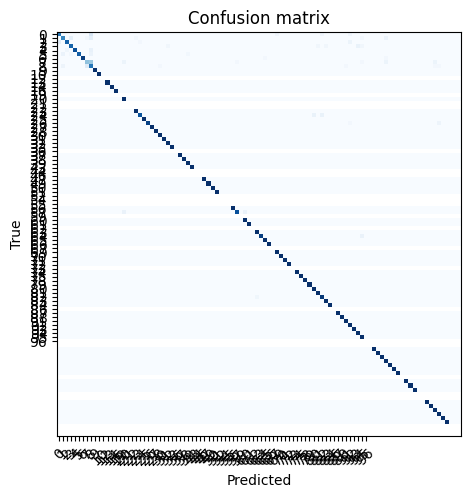

# Test Accuracy: 96.451[%]


In [ ]:
model.eval()

correct = 0
confusion_matrix = np.zeros((100, 100))

with torch.no_grad():
  for batch_idx, (data, label) in enumerate(data_loader['test']):
    if(torch.cuda.is_available()):
      data = data.cuda()
      label = torch.LongTensor(label).cuda()
    else:
      data = data
      label = torch.LongTensor(label)

    output = model(data)

    _, predict = torch.max(output.data, 1)
    correct += (predict == label).sum().item()

    for l, p in zip(label.view(-1), predict.view(-1)):
      confusion_matrix[l.long(), p.long()] += 1

len_cm = len(confusion_matrix)
for i in range(len_cm):
    sum_cm = np.sum(confusion_matrix[i])
    for j in range(len_cm):
        confusion_matrix[i][j] = 100 * (confusion_matrix[i][j] / sum_cm)

classes = np.unique(train_label,return_counts=False)
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.tight_layout()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()


print('# Test Accuracy: {:.3f}[%]'.format(100. * correct / len(data_loader['test'].dataset)))

### Making onnx Models for graphical purpose

In [ ]:
!pip install -q onnx

In [ ]:
input_names = ["Skeleton"]
output_names = ["Parkinson Prediction"]

stgcn_model = STGCN(num_classes=99,
                    in_channels=3,
                    t_kernel_size=9,
                    hop_size=2)

for data, label in data_loader['train']:
  x = data
  break

torch.onnx.export(stgcn_model, x, "stgcn_model.onnx", input_names=input_names, output_names=output_names)